In [3]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

# Loading data to tf.dataset

In [5]:
# Loadig data to tf.dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "train",
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
)

Found 87867 files belonging to 38 classes.


In [6]:
len(dataset)

2746

# Visualization of the loaded images


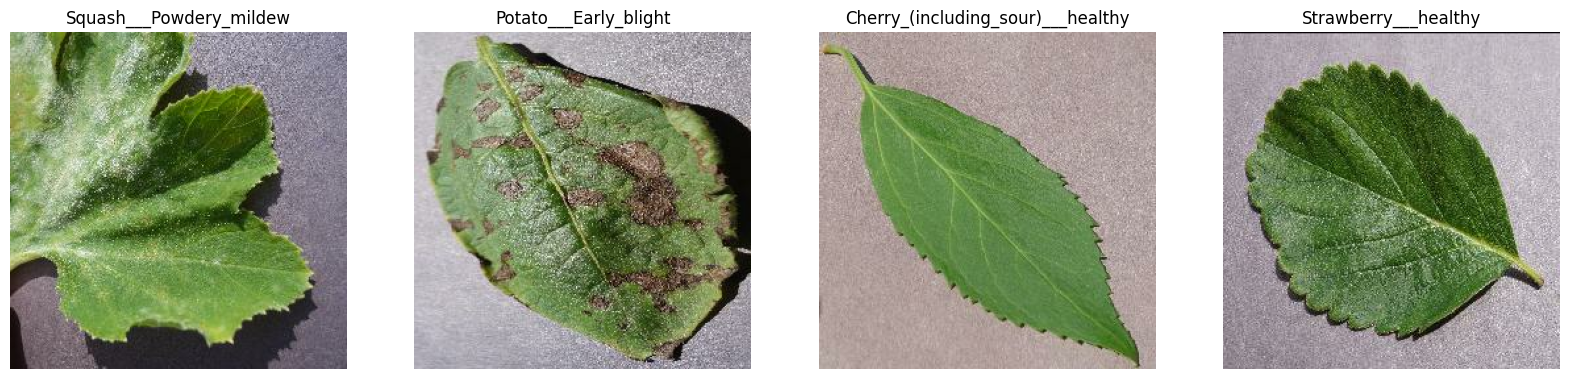

In [7]:
# Visualizing the first 4 images

plt.figure(figsize=(20,20))

for image_batch, label_batch in dataset.take(1):
  for i in range(4):
    ax = plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype('uint8'))
    plt.title(dataset.class_names[label_batch[i]])
    plt.axis('off')

# Splitting the dataset into training and validation sets


In [8]:
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset = dataset.take(train_size)
temp_dataset = dataset.skip(train_size)
val_dataset = temp_dataset.take(val_size)
test_dataset = temp_dataset.skip(val_size)

print(f"Len of train dataset: {len(train_dataset)}")
print(f"Len of validation dataset: {len(val_dataset)}")
print(f"Len of test dataset: {len(test_dataset)}")

Len of train dataset: 2196
Len of validation dataset: 274
Len of test dataset: 276


# Preprocess the data

In [9]:
def preprocess(image, label):
    image = tf.cast(image, tf.float32)
    image = image / 255.0
    return image, label

train_dataset = train_dataset.map(preprocess)
val_dataset = val_dataset.map(preprocess)
test_dataset = test_dataset.map(preprocess)


# Creating the model using Convolutional Neural Network

---



In [19]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(38, activation='softmax')
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])


# Training the model

In [20]:
history = model.fit(train_dataset,
                    validation_data=val_dataset,
                    epochs=10)


Epoch 1/10
2196/2196 [==============================] - 6048s 3s/step - loss: 0.8760 - accuracy: 0.7389 - val_loss: 0.3944 - val_accuracy: 0.8768
Epoch 2/10
2196/2196 [==============================] - 6119s 3s/step - loss: 0.2637 - accuracy: 0.9153 - val_loss: 0.3135 - val_accuracy: 0.9004
Epoch 3/10
2196/2196 [==============================] - 6092s 3s/step - loss: 0.1468 - accuracy: 0.9519 - val_loss: 0.3131 - val_accuracy: 0.9094
Epoch 4/10
2196/2196 [==============================] - 5915s 3s/step - loss: 0.1031 - accuracy: 0.9663 - val_loss: 0.4328 - val_accuracy: 0.8923
Epoch 5/10
2196/2196 [==============================] - 5791s 3s/step - loss: 0.0844 - accuracy: 0.9725 - val_loss: 0.3461 - val_accuracy: 0.9177
Epoch 6/10
2196/2196 [==============================] - 6001s 3s/step - loss: 0.0700 - accuracy: 0.9775 - val_loss: 0.4443 - val_accuracy: 0.9000
Epoch 7/10
2196/2196 [==============================] - 5875s 3s/step - loss: 0.0641 - accuracy: 0.9802 - val_loss: 0.5012 -

In [42]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 64)        36928     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 30, 30, 64)      

# Visualize the training and validation accuracy and loss

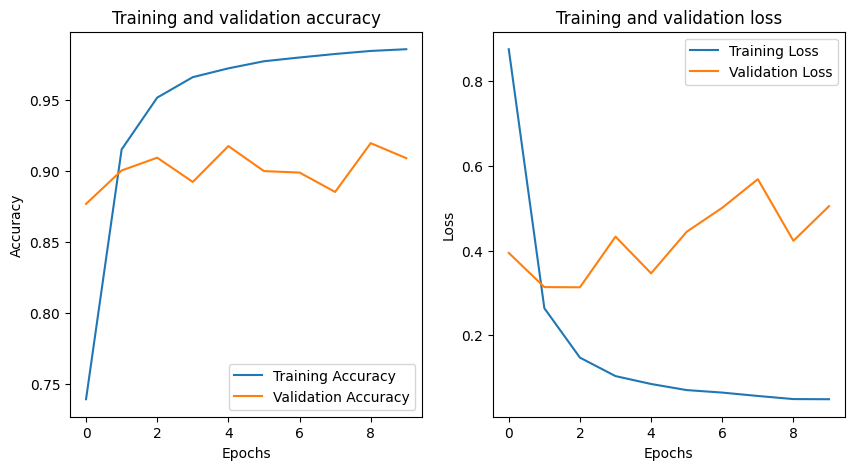

In [29]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [40]:
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.2f}")



276/276 [==============================] - 155s 410ms/step - loss: 0.5220 - accuracy: 0.9051
Test accuracy: 0.91


In [43]:
# Save model
model.save('crop_disease_model.h5')

In [10]:
# Load model

loaded_model = tf.keras.models.load_model('crop_disease_model.h5')

# Fine-tuning with data augmentation and a pre-trained model

In [11]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

# Pre-trained ResNet50 model with custom layers

In [12]:
from tensorflow.keras.applications import ResNet50

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Updated model with data augmentation and additional layers

In [13]:
# Make the pre-trained layers untrainable
for layer in base_model.layers:
    layer.trainable = False

# Create new model using the pre-trained ResNet50 model with added custom layers
fine_tuned_model = models.Sequential([
    data_augmentation,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dense(38, activation='softmax')
])


fine_tuned_model.compile(optimizer='adam',
                     loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                     metrics=['accuracy'])


# Compile and train the fine-tuned model

In [15]:
fine_tuned_history = fine_tuned_model.fit(train_dataset,
                    validation_data=val_dataset,
                    epochs=10)


# Visualizing retrained training and validation accuracy and loss

In [ ]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fine_tuned_history.history['accuracy'], label='Training Accuracy')
plt.plot(fine_tuned_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(fine_tuned_history.history['loss'], label='Training Loss')
plt.plot(fine_tuned_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


In [ ]:
# Evaluate the model
test_loss, test_acc = fine_tuned_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.2f}")

# Save model
fine_tuned_history.save('crop_disease_model_v2.h5')

# Creating an API for the AI model using Flask

In [1]:
import io
import os
import random
import numpy as np
import tensorflow as tf
from flask import Flask, request, jsonify, render_template, send_from_directory
from scipy.special import softmax


app = Flask(__name__)

# Load the trained model
model = tf.keras.models.load_model('crop_disease_model.h5')

# Load the dataset to get the class names
dataset_directory = 'train'

dataset = tf.keras.utils.image_dataset_from_directory(
    dataset_directory,
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
)
class_names = dataset.class_names


@app.route('/')
def index():
    return render_template('index.html')


@app.route('/favicon.ico')
def favicon():
    return send_from_directory(os.path.join(app.root_path, 'static'),
                               'favicon.ico', mimetype='image/vnd.microsoft.icon')


@app.route('/predict', methods=['POST'])
def predict():
    img = request.files['image']
    img_bytes = io.BytesIO(img.read())
    image = tf.keras.preprocessing.image.load_img(img_bytes, target_size=(256, 256))
    input_arr = tf.keras.preprocessing.image.img_to_array(image)
    input_arr = np.array([input_arr])
    predictions = model.predict(input_arr)
    predicted_class = np.argmax(predictions[0])

    class_name = class_names[predicted_class]
    similar_images = get_similar_images(class_name)
    
    # Get the confidence percentage
    confidence = predictions[0][predicted_class] * 100


    return jsonify({"class": class_name, "confidence": confidence, "similar_images": similar_images})


@app.route('/images/<path:filename>', methods=['GET'])
def serve_image(filename):
    return send_from_directory(os.path.join(dataset_directory), filename)


def get_similar_images(class_name):
    class_directory = os.path.join(dataset_directory, class_name)
    all_images = os.listdir(class_directory)
    random.shuffle(all_images)
    selected_images = all_images[:5]
    image_paths = [os.path.join(class_name, img) for img in selected_images]
    return image_paths


if __name__ == '__main__':
    app.run(host='0.0.0.0', port=5000)
    

2023-04-09 21:34:50.822223: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-09 21:34:53.125439: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-09 21:34:53.126620: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Found 87867 files belonging to 38 classes.
 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://192.168.1.79:5000
Press CTRL+C to quit


1/1 [==============================] - 0s 154ms/step


127.0.0.1 - - [09/Apr/2023 21:35:07] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [09/Apr/2023 21:35:07] "GET /images/Strawberry___Leaf_scorch/ea701f0f-ea68-4e99-8db5-d52140ee1e31___RS_L.Scorch%201192_flipLR.JPG HTTP/1.1" 200 -
127.0.0.1 - - [09/Apr/2023 21:35:07] "GET /images/Strawberry___Leaf_scorch/7ac5bc30-d798-4205-a5a6-1235eae3a66d___RS_L.Scorch%201533_flipLR.JPG HTTP/1.1" 200 -
127.0.0.1 - - [09/Apr/2023 21:35:08] "GET /images/Strawberry___Leaf_scorch/13d5364a-7ac5-4c5f-9cf1-23c64499a620___RS_L.Scorch%201342.JPG HTTP/1.1" 200 -
127.0.0.1 - - [09/Apr/2023 21:35:08] "GET /images/Strawberry___Leaf_scorch/bfbc366b-d28e-48d6-9f82-d57535e17889___RS_L.Scorch%209993_flipLR.JPG HTTP/1.1" 200 -
127.0.0.1 - - [09/Apr/2023 21:35:08] "GET /images/Strawberry___Leaf_scorch/670e9f1b-0863-4ae9-b95e-e68f6899a4f5___RS_L.Scorch%200121.JPG HTTP/1.1" 200 -


1/1 [==============================] - 0s 44ms/step


127.0.0.1 - - [09/Apr/2023 21:36:18] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [09/Apr/2023 21:36:18] "GET /images/Apple___Cedar_apple_rust/4d7f4b74-59f6-431e-afa3-6fbbb9ac90ea___FREC_C.Rust%200145_newGRR.JPG HTTP/1.1" 200 -
127.0.0.1 - - [09/Apr/2023 21:36:18] "GET /images/Apple___Cedar_apple_rust/dc75b693-0cd6-4a48-b0a0-e442070df2cc___FREC_C.Rust%209951.JPG HTTP/1.1" 200 -
127.0.0.1 - - [09/Apr/2023 21:36:18] "GET /images/Apple___Cedar_apple_rust/a39baf45-f09c-4b1f-a382-25c8f61f49c0___FREC_C.Rust%204123_new30degFlipLR.JPG HTTP/1.1" 200 -
127.0.0.1 - - [09/Apr/2023 21:36:18] "GET /images/Apple___Cedar_apple_rust/3dc7b8db-79dd-4206-b3f0-7091d28475b2___FREC_C.Rust%200079_new30degFlipTB.JPG HTTP/1.1" 200 -
127.0.0.1 - - [09/Apr/2023 21:36:18] "GET /images/Apple___Cedar_apple_rust/0fbdccdc-fb96-475a-92bb-65734592c895___FREC_C.Rust%203619_newPixel25.JPG HTTP/1.1" 200 -


1/1 [==============================] - 0s 118ms/step


127.0.0.1 - - [09/Apr/2023 21:36:50] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [09/Apr/2023 21:36:50] "GET /images/Strawberry___Leaf_scorch/5a58d8c7-e935-411d-9568-8cfb7a343177___RS_L.Scorch%200139_flipLR.JPG HTTP/1.1" 200 -
127.0.0.1 - - [09/Apr/2023 21:36:50] "GET /images/Strawberry___Leaf_scorch/13971547-97a9-4bc8-b843-93aa3247351d___RS_L.Scorch%200932.JPG HTTP/1.1" 200 -
127.0.0.1 - - [09/Apr/2023 21:36:50] "GET /images/Strawberry___Leaf_scorch/f1c2c618-1be3-4fa3-b3ed-b88ca37f3ade___RS_L.Scorch%201516.JPG HTTP/1.1" 200 -
127.0.0.1 - - [09/Apr/2023 21:36:50] "GET /images/Strawberry___Leaf_scorch/6c1b8a7b-f7c3-4c9d-b04d-c9885df5ed31___RS_L.Scorch%200818.JPG HTTP/1.1" 200 -
127.0.0.1 - - [09/Apr/2023 21:36:50] "GET /images/Strawberry___Leaf_scorch/7f34de3d-eb4b-40f6-a6b3-26f531eb21c8___RS_L.Scorch%201276.JPG HTTP/1.1" 200 -


1/1 [==============================] - 0s 49ms/step


127.0.0.1 - - [09/Apr/2023 21:37:22] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [09/Apr/2023 21:37:22] "GET /images/Apple___Black_rot/789c7185-b853-4638-b621-03ee71ce0c7e___JR_FrgE.S%208641_90deg.JPG HTTP/1.1" 200 -
127.0.0.1 - - [09/Apr/2023 21:37:22] "GET /images/Apple___Black_rot/36836204-c6de-472e-90e4-6787ff74965e___JR_FrgE.S%208757.JPG HTTP/1.1" 200 -
127.0.0.1 - - [09/Apr/2023 21:37:22] "GET /images/Apple___Black_rot/788885e1-18b4-44a0-af85-226e66265220___JR_FrgE.S%208574_270deg.JPG HTTP/1.1" 200 -
127.0.0.1 - - [09/Apr/2023 21:37:22] "GET /images/Apple___Black_rot/6b078700-56e6-4d25-a18a-b7b90741a2d3___JR_FrgE.S%202963.JPG HTTP/1.1" 200 -
127.0.0.1 - - [09/Apr/2023 21:37:22] "GET /images/Apple___Black_rot/1aa28af5-8270-467c-b496-ff415f0b58df___JR_FrgE.S%203010_new30degFlipLR.JPG HTTP/1.1" 200 -
